# Загружаем нужные пакеты

In [6]:
#%tensorflow_version 2.x
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils
from keras import regularizers
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore')

import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn import model_selection, datasets, linear_model, metrics
from scipy import stats
from matplotlib.colors import ListedColormap

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from  xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Загружаем данные

In [8]:
#считываем данные
original_data = pd.read_csv('Отчетность SP 1500 2012-2020.txt')
print(original_data[0:3])

   Ind  Year  Quarter         4          5          6          7          8  \
0    1  2012        3  1.892371  53.321601  22.627951  15.045264   9.695520   
1    1  2012        4  2.256944  53.295421  22.557597  12.695196 -11.391583   
2    1  2013        1  2.752294  52.962480  22.077358  11.799023 -21.559957   

          9         10    11        12         13        14        15  \
0  0.000000   0.000000   0.0  0.000000   0.000000  0.000000  0.000000   
1 -3.193196 -33.342784 -62.5  8.100686   8.129295 -2.539683 -3.191489   
2  5.136147 -33.096668   0.0  8.253095  16.171787  2.558140 -5.612245   

         16  
0  0.000000  
1 -3.544776  
2  2.010969  


In [9]:
#!!! Так как данные уже в процентных отклонениях, не нужно выполнять этот блок!!!
#Отчетность SP 400 + 500 (278) 2000-2015.txt
#raw_data = np.array(raw_data)
#data = raw_data.copy()
#for i in range(3,data.shape[0]):
#  if raw_data[i,0] == raw_data[i-4,0]:
#    for j in range(1,15):
#      if raw_data[i-4,j] == 0 or raw_data[i,j] == 0:
#        data[i,j] = 0
#      else:
#        data[i,j] = (raw_data[i,j] - raw_data[i-4,j]) / raw_data[i-4,j] * 100

#print(data[0:14,4])

In [10]:
#Делаем столбец изменения капитализации последним
original_data = np.array(original_data)
data = original_data.copy()
last_array = data[:,8].copy()
data = np.delete(data, 8, axis=1)
last_array = last_array.reshape(last_array.shape[0],1)
data = np.hstack((data, last_array))

# Проверяем что правильно передвинули капитализацию в последний столбец.
print(original_data[5])
print(data[5])

[ 1.00000000e+00  2.01300000e+03  4.00000000e+00 -2.77306200e+00
  5.24329106e+01  2.11589502e+01  1.24515363e+01 -8.66232697e-02
  3.57400177e+01  1.37813696e+01  0.00000000e+00  1.42675699e+01
  3.58041606e+01 -6.18892508e+00 -5.15463918e-01 -7.44680851e+00]
[ 1.00000000e+00  2.01300000e+03  4.00000000e+00 -2.77306200e+00
  5.24329106e+01  2.11589502e+01  1.24515363e+01 -8.66232697e-02
  1.37813696e+01  0.00000000e+00  1.42675699e+01  3.58041606e+01
 -6.18892508e+00 -5.15463918e-01 -7.44680851e+00  3.57400177e+01]


Среднее изменение капитализации:  14.743408005241992


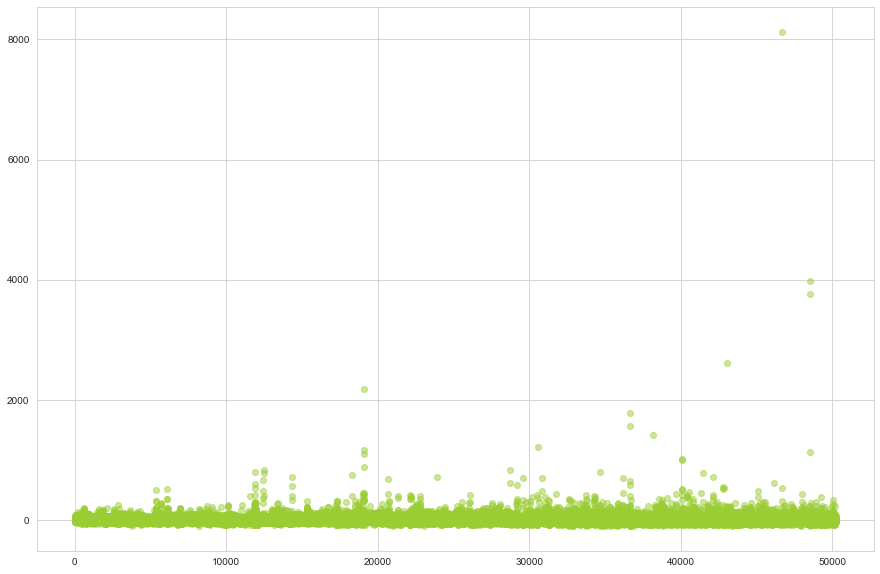

In [11]:
# Смотрим на значения изменений капитализации
print('Среднее изменение капитализации: ', data[:,15].mean())
plt.figure(figsize=(15,10))
plt.scatter(range(0,len(data[:,15])), data[:,15], color=('yellowgreen'), alpha=0.5)

In [12]:
# Очищаем данные от выбросов изменений капитализации. 
print('Изначальные данные:', data.shape)
clear_data = []                    # Берется везде i+5, потому что прогнозируем ровно на год вперед, данные i периода включены в обучение.
for i in range(0,len(data)-5):
  if data[i+5,1] <= 2017  and data[i,15] < 700 and data[i,15] > -100:  # Убирем большие изм Цены только в обучающей выборке
    clear_data.append(data[i])
  elif data[i+5,1] < 2021 and data[i,15] < 1000 and data[i,15] > -100: # В тестовой убираются только Супербольшие изм цены.
    clear_data.append(data[i])

clear_data = np.array(clear_data)
print('Очищенные данные:', clear_data.shape)

Изначальные данные: (50211, 16)
Очищенные данные: (49466, 16)


Среднее изменение капитализации без выбросов:  14.338261255106172


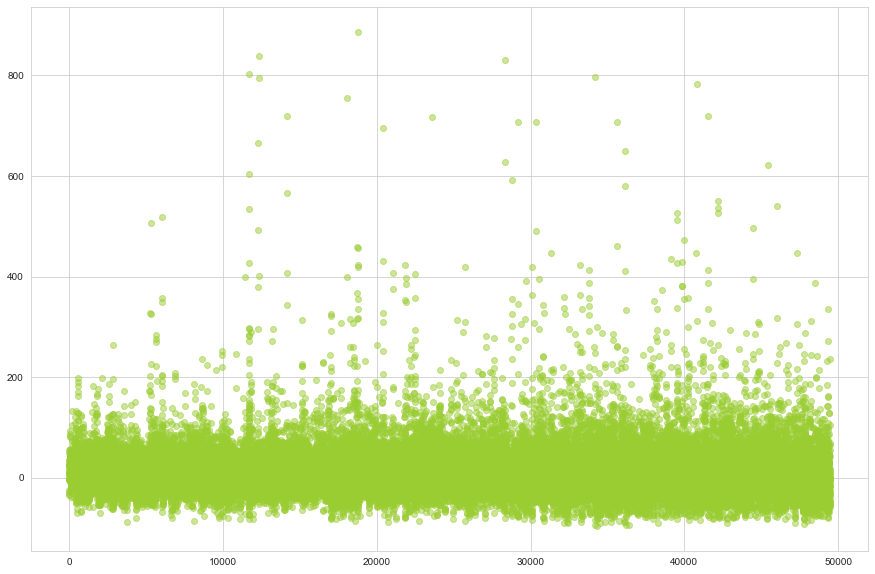

In [13]:
# Смотрим на значения изменений капитализации
print('Среднее изменение капитализации без выбросов: ',clear_data[:,15].mean())
plt.figure(figsize=(15,10))
plt.scatter(range(0,len(clear_data[:,15])), clear_data[:,15], color=('yellowgreen'), alpha=0.5)

<AxesSubplot:ylabel='Count'>

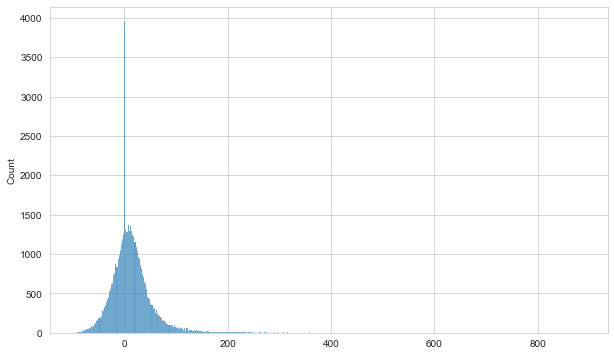

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(clear_data[:,15])

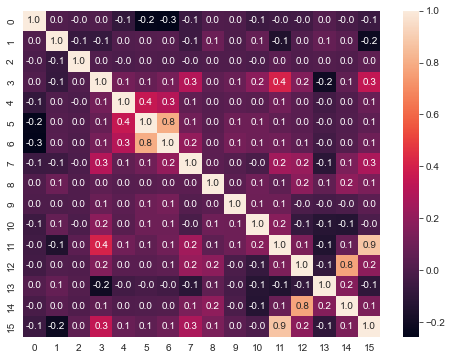

In [15]:
# Попарная корреляция признаков
plt.figure(figsize=(8, 6))
clear_data_df = pd.DataFrame(clear_data.copy())
sns.heatmap(clear_data_df.corr(method='spearman'), annot=True, fmt=".1f");

In [16]:
#Нормализация данных по обучающей выборке. Не забывать менять в соответствии с размером и датами обучающей выборки!

#for j in range(3,14):
#  mean = clear_data[:,j].mean()
#  std = clear_data[:,j].std()
#  clear_data[:,j] = clear_data[:,j] - mean
#  clear_data[:,j] = clear_data[:,j] / std
#

In [17]:
# Подготавливаем данные

# число прошлых кварталов как признаки для модели
n_steps = 7

prepared_data = []
prepared_data_test = []
target = []
target_test = []
train_indexes = []
test_indexes = []

periods_out_smpl = 1

for i in range(n_steps, clear_data.shape[0]-8, n_steps):  # по умолчанию шаг n_steps, но можно попробовать меньше чем n_steps и больше периода прогноза!!!
  current_string = []
  if clear_data[i+5,0] == clear_data[i-n_steps,0]:
    # Подготовка тестовой выборки
    if clear_data[i+5,1] > 2016 and clear_data[i+5,1] <= 2018:  
      for l in range(0,periods_out_smpl):
        current_string_test = []
        for j in range(3,16): # !!! Важно убрать дату, квартал и Индекс акции!!!
          for k in range(1,n_steps+1):       
            current_string_test.append(clear_data[i-n_steps+k,j])
        prepared_data_test.append(current_string_test)
        target_test.append(clear_data[i+5,15])                     # Здесь берется будущее именно уже измененеие капитализации (из файла)
        test_indexes.append(clear_data[i+5,0])
    # Подготовка обучающей выборки
    #elif clear_data[i+4,1] <= 2019: #or (clear_data[i+4,1] == 2020 and clear_data[i+4,2] < 3):  
    elif clear_data[i+5,1] <= 2016 :
      for j in range(3,16):
        for k in range(1,n_steps+1):
          current_string.append(clear_data[i-n_steps+k,j])          
      prepared_data.append(current_string)
      target.append(clear_data[i+5,15])
      train_indexes.append(clear_data[i+5,0])

prepared_data = np.array(prepared_data)
target = np.array(target)

prepared_data_test = np.array(prepared_data_test)
target_test = np.array(target_test)

print(prepared_data.shape)
print(target.shape)
print(prepared_data_test.shape)
print(target_test.shape)

(1267, 91)
(1267,)
(1597, 91)
(1597,)


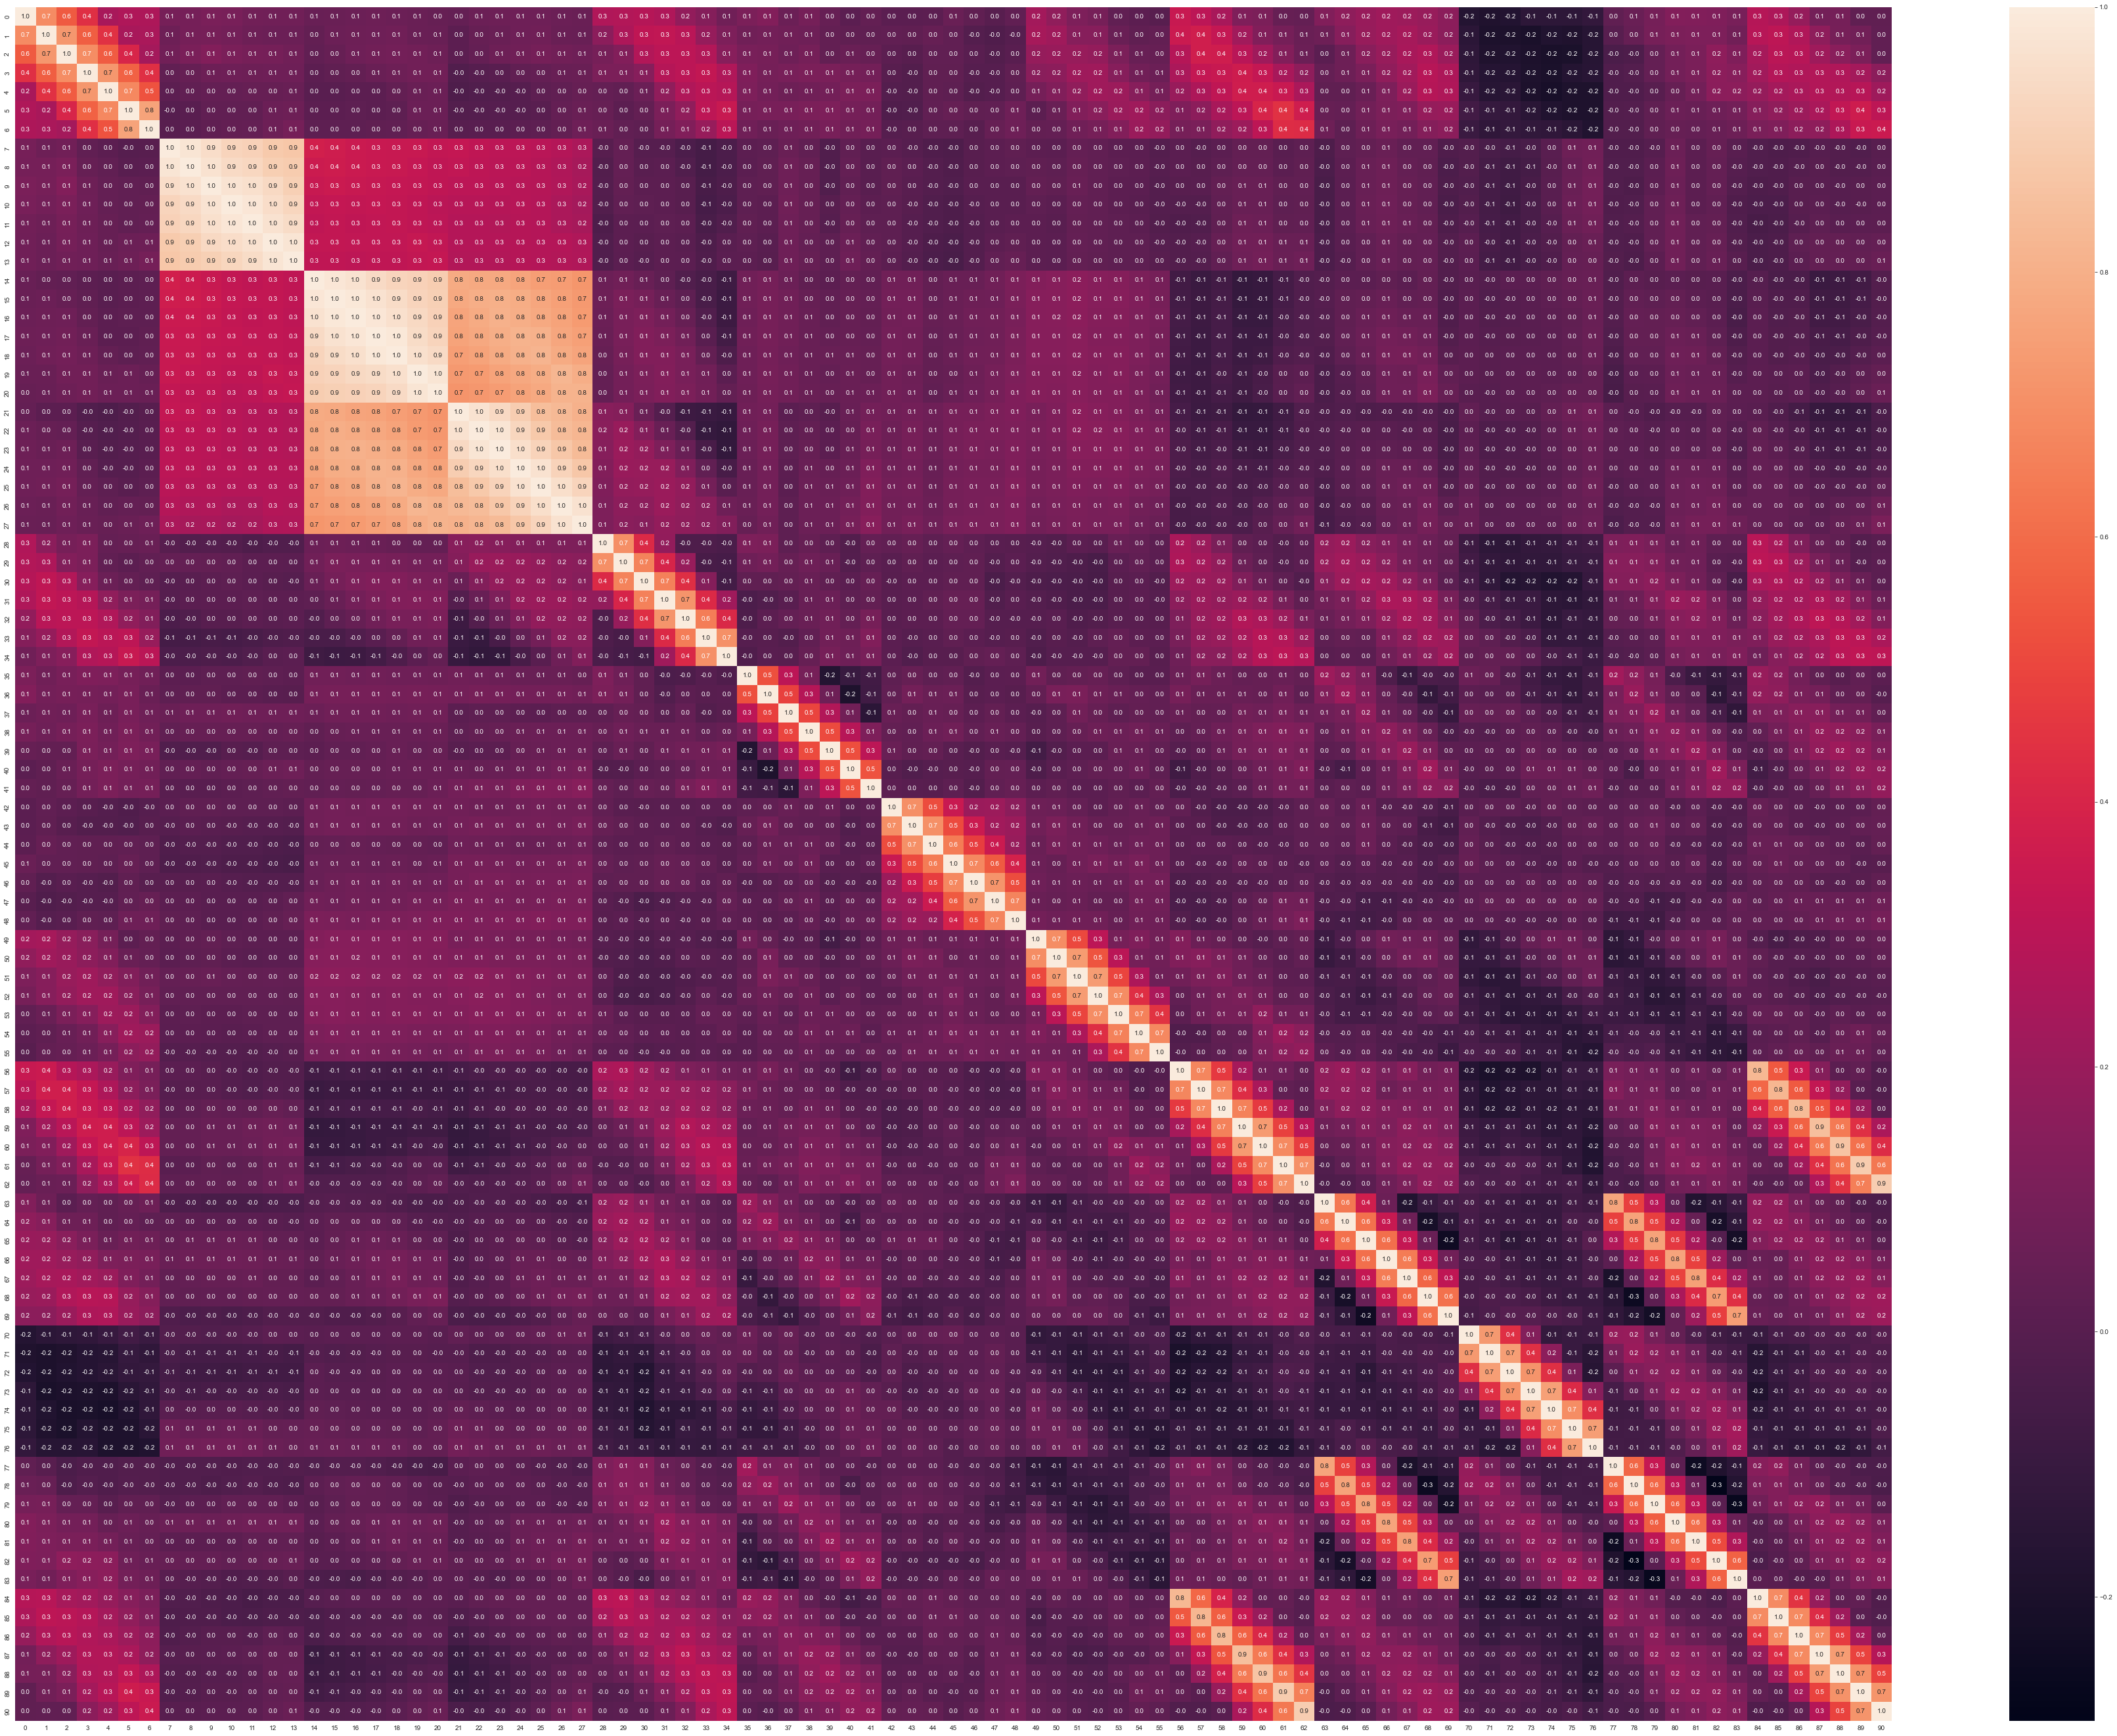

In [22]:
# Попарная корреляция подготовленных признаков за n_steps периодов
plt.figure(figsize=(64, 48))
prepared_data_df = pd.DataFrame(prepared_data)
sns.heatmap(prepared_data_df.corr(method='spearman'), annot=True, fmt=".1f");

In [23]:
# Подготавливаем данные. Дополнительно добавлено условие последовательности кварталов

# число прошлых кварталов как признаки для модели
n_steps = 7

prepared_data = []
prepared_data_test = []
target = []
target_test = []
train_indexes = []
test_indexes = []

periods_out_smpl = 1
for i in range(n_steps, clear_data.shape[0]-8, n_steps):  # по умолчанию шаг n_steps, но можно попробовать меньше чем n_steps и больше периода прогноза!!!
  current_string = []
  correct_sequence = True

  if clear_data[i+5,0] == clear_data[i-n_steps,0]:
    for k in range(1,n_steps+4+1):
      if ((clear_data[i-(n_steps-1)+k,2] - clear_data[i-(n_steps-1)+k-1,2]) == 1 or
      (clear_data[i-(n_steps-1)+k-1,2] - clear_data[i-(n_steps-1)+k,2] == 3  and
      clear_data[i-(n_steps-1)+k,1] - clear_data[i-(n_steps-1)+k-1,1] == 1)) == False:
        correct_sequence = False
        

    if (correct_sequence == True and clear_data[i+5,1] > 2016  and clear_data[i+5,1] <= 2018): #or (clear_data[i+4,1] > 2017 and clear_data[i+4,2] < 0): #and data[i+4,2] > 2:  # Подготовка тестовой выборки
      for l in range(0,periods_out_smpl):
        current_string_test = []
        for j in range(3,16): # !!! Важно убрать дату, квартал и Индекс акции!!!
          for k in range(1,n_steps+1):
            current_string_test.append(clear_data[i-n_steps+k,j])  
        prepared_data_test.append(current_string_test)
        target_test.append(clear_data[i+5,15])
        test_indexes.append(clear_data[i+5,0])
    elif correct_sequence == True and clear_data[i+5,1] <= 2016: # Подготовка обучающей выборки
      for j in range(3,16):
        for k in range(1,n_steps+1):
          current_string.append(clear_data[i-n_steps+k,j])

      prepared_data.append(current_string)
      target.append(clear_data[i+5,15])
      train_indexes.append(clear_data[i+5,0])
    
prepared_data = np.array(prepared_data)
target = np.array(target)

prepared_data_test = np.array(prepared_data_test)
target_test = np.array(target_test)
train_indexes = np.array(train_indexes)
test_indexes = np.array(test_indexes)

print(prepared_data.shape)
print(target.shape)
print(prepared_data_test.shape)
print(target_test.shape)

print('target.mean',target.mean())
print('target_test.mean',target_test.mean())

(1264, 91)
(1264,)
(1592, 91)
(1592,)
target.mean 8.269699862079024
target_test.mean 18.744685353923145


# Анализируем возможности модели для торговли

In [24]:
# Кроссвалидация
#Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1000,
                        max_depth=10,
                        max_features=None,
                        oob_score=True,
                        random_state=42)

cross_val = cross_val_score(rf, prepared_data, target, scoring = 'neg_mean_absolute_error', cv = 4)
print(cross_val, cross_val.mean(), cross_val.max(), cross_val.min())

[-21.6606962  -23.45906703 -29.63719396 -30.86084682] -26.40445100368363 -21.660696200037826 -30.860846820175436


In [25]:
# Записываем результаты обученной модели
start = datetime.now()
all_predictions = []
all_ansvers = []
sigmas = []

x_train = prepared_data
y_train = target
x_test = prepared_data_test
y_test = target_test

#lasso_regressor = linear_model.Lasso()
#lasso_regressor.fit(x_train, y_train)
#predictions = lasso_regressor.predict(x_test)

#linear_regressor = linear_model.LinearRegression()
#linear_regressor.fit(x_train, y_train)
#predictions = linear_regressor.predict(x_test)

#Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1000,
                        max_depth=10,
                        max_features=None,
                        oob_score=True,
                        random_state=42)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)

 #Gradient Boosting
#xgb = XGBRegressor(
#                  n_estimators=80, #default=100
#                  max_depth=5,     #default=3
#                  max_features=None,  #default=None
#                  random_state=42)
#xgb.fit(x_train, y_train)
#predictions = xgb.predict(x_test)

finish = datetime.now()
time_consumed = finish - start
print('start:', start)
print('finish:', finish)
print('time_consumed:', time_consumed)

start: 2023-02-13 22:37:57.230903
finish: 2023-02-13 22:39:03.799903
time_consumed: 0:01:06.569000


<BarContainer object of 91 artists>

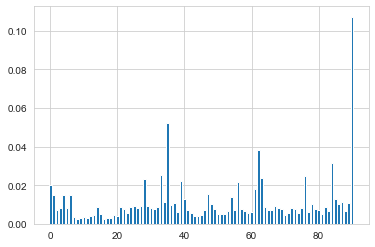

In [26]:
# Значимость признаков
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)

In [27]:
#predictions = xgb.predict(prepared_data_test)

In [28]:
print(predictions.shape)
print(y_test.shape)

(1592,)
(1592,)


# Выбираем Подходящее отклонение на тестовых данных

In [29]:
strings_count = int(np.array(predictions.shape))

results_by_otkl = []
indx_list = []
 
min_otkl = 10
max_otkl = 100
step = 4

indx_filtr = 0
for otkl in np.arange(min_otkl, max_otkl, step):
  results = []
  max_rslt = 0
  deals_count = 0
  profit = 0
  loss = 0
  for i in range(0, strings_count):
    if predictions[i] > otkl:
        curr_rslt = y_test[i]
          #max_rslt = max(max_rslt, curr_rslt)      # Убираю 1 максимальное значение
        if curr_rslt > 0 and curr_rslt < 1000:
          profit = profit + curr_rslt
          deals_count = deals_count + 1
        if curr_rslt <= 0 and curr_rslt > -101:
          loss = loss + curr_rslt
          deals_count = deals_count + 1
  if loss == 0:
    P_E = 0
  else:
    P_E = -profit / (loss - max_rslt)          # Убираю 1 максимальное значение
  overal_profit = profit + loss - max_rslt     # Убираю 1 максимальное значение
  if deals_count == 0:
    profit_per_deal = 0
  else:
    profit_per_deal = overal_profit / (deals_count - 1) # Убираю 1 максимальное значение
  results_by_otkl.append([profit_per_deal,P_E,overal_profit,profit,loss,deals_count])


print('target.mean',target.mean())
print('target_test.mean',target_test.mean()) 
results_by_otkl = pd.DataFrame(results_by_otkl, columns=['per_deal','P_E','overal_profit','profit','loss','count']).round(2)
results_by_otkl.insert(0,'otkl', np.arange(min_otkl, max_otkl, step))
print(results_by_otkl)
print(indx_list)

target.mean 8.269699862079024
target_test.mean 18.744685353923145
    otkl  per_deal    P_E  overal_profit    profit     loss  count
0     10     26.93   5.59       12090.49  14727.07 -2636.58    450
1     14     29.04   5.23        7665.42   9476.41 -1810.99    265
2     18     30.93   5.52        5041.30   6157.59 -1116.29    164
3     22     30.39   5.02        3403.85   4250.90  -847.05    113
4     26     27.56   4.44        2204.60   2846.21  -641.61     81
5     30     27.14   3.79        1465.52   1991.22  -525.69     55
6     34     29.26   3.78        1316.68   1790.11  -473.43     46
7     38     32.26   4.22        1193.48   1563.73  -370.24     38
8     42     37.37   4.67        1008.98   1283.65  -274.67     28
9     46     35.59   4.11         854.08   1128.75  -274.67     25
10    50     51.86   7.70         881.64   1013.18  -131.54     18
11    54     61.64  11.43         924.58   1013.18   -88.60     16
12    58     66.33   9.53         729.68    815.20   -85.52    

In [30]:
# Смотрим по одному из отклонений Прогнозы и реальные изменения капитализации компаний.
otkl = 42
subset_predict = []
subset_rslt = []
for i in range(0, strings_count):
    if predictions[i] > otkl:
      subset_predict.append(predictions[i])
      subset_rslt.append(y_test[i])

subset = pd.DataFrame(subset_predict, columns=['subset_predict'])
subset.insert(1, 'subset_rslt', subset_rslt)
print(subset)

    subset_predict  subset_rslt
0        49.679280    23.645963
1        54.294393    -3.084004
2        62.624288    77.455105
3        80.858872    15.995127
4        45.782473     9.575076
5        65.557794    59.888564
6        63.217928    49.062130
7        64.337202    25.728044
8        78.135430   108.310398
9       139.660682   345.903994
10       46.378394   -43.489056
11       55.613966    19.297893
12       52.349391   -21.116420
13       70.961356   -54.873084
14       44.779988   142.851485
15       51.025484   -21.822733
16       57.496789   102.039777
17       64.804555   -30.647018
18       46.101637   -60.399047
19      146.564952    38.188120
20       48.011301   -28.720273
21       56.019957    76.650643
22      183.515049    73.895778
23       47.837041    72.659908
24       46.299547    19.260532
25       46.925665   -10.521739
26       43.081763     2.476536
27       65.798413    20.768771


# Тест Out of smpl, отбор акций с прогнозами выше выбранного порогового значения 

In [31]:
# Подготавливаем данные еще раз, теперь обучаемся и на данных что были в тесте для выбора наилочшего порога прогнозов для отбора акций (Дополнительно добавлено условие последовательности кварталов)

# число прошлых кварталов как признаки для модели
n_steps = 7

prepared_data = []
prepared_data_test = []
target = []
target_test = []
train_indexes = []
test_indexes = []

periods_out_smpl = 1
for i in range(n_steps, clear_data.shape[0]-8, n_steps):  # по умолчанию шаг n_steps, но можно попробовать меньше чем n_steps и больше периода прогноза!!!
  current_string = []
  correct_sequence = True

  if clear_data[i+5,0] == clear_data[i-n_steps,0]:
    for k in range(1,n_steps+4+1):
      if ((clear_data[i-(n_steps-1)+k,2] - clear_data[i-(n_steps-1)+k-1,2]) == 1 or
      (clear_data[i-(n_steps-1)+k-1,2] - clear_data[i-(n_steps-1)+k,2] == 3  and
      clear_data[i-(n_steps-1)+k,1] - clear_data[i-(n_steps-1)+k-1,1] == 1)) == False:
        correct_sequence = False
        
    if (correct_sequence == True and clear_data[i+5,1] > 2018  and clear_data[i+5,1] <= 2023): #or (clear_data[i+4,1] > 2017 and clear_data[i+4,2] < 0): #and data[i+4,2] > 2:  # Подготовка тестовой выборки
      for l in range(0,periods_out_smpl):
        current_string_test = []
        for j in range(3,16): # !!! Важно убрать дату, квартал и Индекс акции!!!
          for k in range(1,n_steps+1):
            current_string_test.append(clear_data[i-n_steps+k,j])  
        prepared_data_test.append(current_string_test)
        target_test.append(clear_data[i+5,15])
        test_indexes.append(clear_data[i+5,0])
    elif correct_sequence == True and clear_data[i+5,1] <= 2018: # Подготовка обучающей выборки
      for j in range(3,16):
        for k in range(1,n_steps+1):
          current_string.append(clear_data[i-n_steps+k,j])

      prepared_data.append(current_string)
      target.append(clear_data[i+5,15])
      train_indexes.append(clear_data[i+5,0])
    
prepared_data = np.array(prepared_data)
target = np.array(target)

prepared_data_test = np.array(prepared_data_test)
target_test = np.array(target_test)
train_indexes = np.array(train_indexes)
test_indexes = np.array(test_indexes)

print(prepared_data.shape)
print(target.shape)
print(prepared_data_test.shape)
print(target_test.shape)

print('target.mean',target.mean())
print('target_test.mean',target_test.mean())

(2856, 91)
(2856,)
(1440, 91)
(1440,)
target.mean 14.108697377140592
target_test.mean 2.092670916895327


In [32]:
# Записываем результаты обученной модели
start = datetime.now()
all_predictions = []
all_ansvers = []
sigmas = []

x_train = prepared_data
y_train = target
x_test = prepared_data_test
y_test = target_test

#lasso_regressor = linear_model.Lasso()
#lasso_regressor.fit(x_train, y_train)
#predictions = lasso_regressor.predict(x_test)

#linear_regressor = linear_model.LinearRegression()
#linear_regressor.fit(x_train, y_train)
#predictions = linear_regressor.predict(x_test)

#Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1000,
                        max_depth=10,
                        max_features=None,
                        oob_score=True,
                        random_state=42)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)

 #Gradient Boosting
#xgb = XGBRegressor(
#                  n_estimators=80, #default=100
#                  max_depth=5,     #default=3
#                  max_features=None,  #default=None
#                  random_state=42)
#xgb.fit(x_train, y_train)
#predictions = xgb.predict(x_test)

finish = datetime.now()
time_consumed = finish - start
print('start:', start)
print('finish:', finish)
print('time_consumed:', time_consumed)

start: 2023-02-13 22:59:44.224605
finish: 2023-02-13 23:02:33.055658
time_consumed: 0:02:48.831053


In [33]:
# Смотрим по выбранному порогу прогноза результаты на контрольных данных.

otkl = 42

strings_count = int(np.array(predictions.shape))
subset_predict = []
subset_rslt = []
for i in range(0, strings_count):
    if predictions[i] > otkl:
      subset_predict.append(predictions[i])
      subset_rslt.append(y_test[i])

subset = pd.DataFrame(subset_predict, columns=['subset_predict'])
subset.insert(1, 'subset_rslt', subset_rslt)
print(subset)
print('Результат по прогнозам: ',subset['subset_rslt'].mean())
print('Среднее всей контрольной выборки: ', y_test.mean())
print('Среднее части контрольной выборки: ', y_test[0:700].mean())

    subset_predict  subset_rslt
0        42.222875   -30.516056
1        63.010493     6.933407
2        99.826356   175.128901
3        49.234738    16.752710
4        47.787633   -45.766628
5        43.351313     2.255241
6        47.603382    20.273617
7        51.316825     2.192758
8        55.637954   -13.363224
9        64.513306     8.010958
10       77.343979   -17.690957
11       54.997105    13.677648
12       44.150622   -42.452193
13       57.158137   -22.994565
14       91.553655   327.653931
15       60.614578   -92.978341
16       51.060853   127.317983
17       42.530567    40.001256
18       52.315839   -51.138903
19       67.826975    62.074021
20       43.854670   -81.293167
21       52.249766     0.021663
22       47.252362   -32.214599
23       55.749230    52.161697
24       70.385680   429.740588
25       58.446003   -21.463468
26       67.891300    35.838207
27       91.060232    55.463066
28       58.490220    62.379923
29       75.301082   -15.954782
30      

# Проанализируем статистическую значимость результатов

In [52]:
np.random.default_rng(seed=3)
rand_indexes = np.random.randint(0, strings_count, len(subset))
random_results = []
for i in range(0,len(rand_indexes)):
  random_results.append(y_test[rand_indexes[i]])

random_results = np.array(random_results)
print(random_results.mean())

6.533633281815144


Двухвыборочный z-критерий

In [53]:
from statsmodels.stats.weightstats import zconfint

zconf = zconfint(subset['subset_rslt'],random_results)
print(f'95%% confidence interval for the mean: {zconf}',)

95%% confidence interval for the mean: (-16.916213296723086, 59.448823611723256)


Ранговый критерий Манна-Уитни

In [54]:
from scipy import stats
print(stats.mannwhitneyu(subset['subset_rslt'],random_results))

MannwhitneyuResult(statistic=656.0, pvalue=0.6134981658350444)


Формальные статистические критерии не позволяют сделать вывод о том что результаты прогнозов лучше чем случайный портфель, однако данный подход все может иметь парктическую значимость.

# Далее можно сделать прогнозы на будущее по последнему кварталу имеющихся данных

In [80]:
# Подготавливливаю отдельно данные для прогноза на будущее, для анализа резальтатов акций по выбранному порогу величины прогноза изменения капитализации.
n_steps = 7

prepared_data_for_future = []
indexes_for_future = []

for i in range(n_steps, clear_data.shape[0], 5):
  current_string = []
  if clear_data[i,0] == clear_data[i-n_steps,0] and clear_data[i,1] == 2021 and clear_data[i,2] == 4:
    current_string_for_future = []
    for j in range(3,16):
        for k in range(1,n_steps+1):
            current_string_for_future.append(clear_data[i-n_steps+k,j])
    prepared_data_for_future.append(current_string_for_future)
    indexes_for_future.append(clear_data[i,0])


prepared_data_for_future = np.array(prepared_data_for_future)
print(prepared_data_for_future.shape)

(2445, 91)


In [ ]:
predictions_for_future = xgb.predict(prepared_data_for_future)
print('done')

done


In [ ]:
predictions_for_future = rf.predict(prepared_data_for_future)
print('done')

done


In [ ]:
# Записываем предсказания
ansvers_to_write = pd.DataFrame(predictions_for_future)
ansvers_to_write.to_csv('drive/My Drive/Data/predictions_for_future_SP_1500.csv')

indexes_to_write = pd.DataFrame(indexes_for_future)
indexes_to_write.to_csv('drive/My Drive/Data/indexes_for_future_SP_1500.csv')

In [ ]:
predictions_for_future = np.array(predictions_for_future)
raw_indexes = np.argsort(predictions_for_future)
best_raw_indexes = np.array(raw_indexes[-40:].copy())
#best_raw_indexes = np.reshape(best_raw_indexes,raw_indexes[-30:].shape[0])
print(best_raw_indexes)
print(predictions_for_future[best_raw_indexes])
original_indexes = []
for i in range(0,best_raw_indexes.shape[0]):
  original_indexes.append(indexes_for_future[best_raw_indexes[i]])

original_indexes = np.array(original_indexes)
print('original_indexes:', original_indexes)

[ 758  671  482  767  425  232  499  114  752  647  855  613 1100  864
  785  888 1032  488 1187  811  875 1173  786  703 1118  543 1102  935
 1145  803  724  959  423  794  929 1188 1175 1104 1059  787]
[ 758  671  482  767  425  232  499  114  752  647  855  613 1100  864
  785  888 1032  488 1187  811  875 1173  786  703 1118  543 1102  935
 1145  803  724  959  423  794  929 1188 1175 1104 1059  787]
[ 55.23550342  55.39895804  55.90837707  56.26129125  57.05291451
  57.40019573  60.48445668  61.82923658  67.39041448  69.6483798
  71.86019398  75.27612127  82.05505655  86.75818511  87.7019382
  87.8440232   91.4340916   95.20460445  95.88847136  96.44328305
 100.04089345 104.2695527  107.86632149 110.51653578 114.42544109
 123.69434319 128.81193296 130.15462004 156.04149773 178.8642245
 189.01375983 195.81273108 200.4958119  267.16818066 326.76852186
 331.51310702 333.36896603 420.79502018 438.00961378 647.1739009 ]
original_indexes: [ 904.  796.  565.  917.  487.  270.  585.  133.

In [ ]:
predictions_values = np.array(predictions_for_future.copy())
predictions_values = np.msort(predictions_values)
print(predictions_values[-40:])
print(predictions_values.shape)

[ 55.23550342  55.39895804  55.90837707  56.26129125  57.05291451
  57.40019573  60.48445668  61.82923658  67.39041448  69.6483798
  71.86019398  75.27612127  82.05505655  86.75818511  87.7019382
  87.8440232   91.4340916   95.20460445  95.88847136  96.44328305
 100.04089345 104.2695527  107.86632149 110.51653578 114.42544109
 123.69434319 128.81193296 130.15462004 156.04149773 178.8642245
 189.01375983 195.81273108 200.4958119  267.16818066 326.76852186
 331.51310702 333.36896603 420.79502018 438.00961378 647.1739009 ]
(1192,)
